In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
%matplotlib inline

os.chdir('..\..\..\..')
print(os.getcwd())

from input_configuration import base_year

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


E:\projects\clients\PierceCounty\Models\BaseYear\Development\PierceCast


In [2]:
working_dir = r'outputs/agg/dash'
# pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///inputs/db/soundcast_inputs.db',
        columns=['CountyName','ParcelID'])

# Usual School Distance

In [5]:
person = pd.read_csv(r'outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pspcl', right_on='ParcelID', how='left')

In [7]:
for col in person.columns:
    print(col)

id
hhno
pno
pptyp
pagey
pgend
pwtyp
pwpcl
pwtaz
pwautime
pwaudist
pstyp
pspcl
pstaz
psautime
psaudist
puwmode
puwarrp
puwdepp
ptpass
ppaidprk
pdiary
pproxy
psexpfac
source
CountyName
ParcelID


In [8]:
pd.options.display.float_format = '{:,.0f}'.format
print(person['CountyName'].value_counts())
print("\n Only 23% of the data has County or TAZ info labelled")

King         502774
Pierce       205204
Snohomish    173168
Kitsap        54766
Name: CountyName, dtype: int64

 Only 23% of the data has County or TAZ info labelled


In [9]:
person['wt_psautime'] = person['psautime']*person['psexpfac']
person['wt_psaudist'] = person['psaudist']*person['psexpfac']

### Average Distance for **All Students**

In [10]:
pd.options.display.float_format = '{:0,.2f}'.format
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model    4.20
survey   4.97
dtype: float64

#### Average Distance by School County

In [11]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.24,4.87
Kitsap,4.11,5.08
Pierce,4.40,3.76
Snohomish,3.87,6.96


### Average Distance for **University** Students only

In [12]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 5)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     6.06
survey   10.07
dtype: float64

#### Average Distance by School County

In [13]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,5.53,8.18
Kitsap,8.54,10.79
Pierce,6.52,8.54
Snohomish,7.05,18.60


#### Top 10 University TAZs

In [14]:
_df = person_survey[person_survey['pptyp'] == 5]
_df = _df[_df['psaudist'] > 0]
# Top 10 College Destinations
n = 10
top10_college = _df['pstaz'].value_counts()[:n].index.tolist()

_df['wt_psaudist'] = _df['psaudist']*_df['psexpfac']
survey_avg = _df[_df['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','wt_psaudist']]
survey_avg['average_survey'] = survey_avg['wt_psaudist']/survey_avg['psexpfac']

# add survey count as we;ll
person_count = person_survey[(person_survey['pptyp'] == 5) & (person_survey['psaudist'] >0)]
person_count = person_count.groupby('pstaz').count()[['hhno']].reset_index()
person_count.rename(columns={'hhno': 'sample_count'}, inplace=True)
survey_avg = survey_avg.merge(person_count, left_index=True, right_on='pstaz')

In [15]:
model_avg = person[person['pptyp'] == 5]
model_avg = model_avg[model_avg['psaudist'] > 0]
model_avg = model_avg[model_avg['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','psaudist']]
model_avg['average_model'] = model_avg['psaudist']/model_avg['psexpfac']
model_avg = model_avg.reset_index()

In [16]:
pd.options.display.float_format = '{:0,.2f}'.format
_df = model_avg[['average_model','pstaz']].merge(survey_avg[['average_survey','sample_count','pstaz']], on='pstaz')
# _df[~_df.average_survey.isnull()]
_df

,average_model,pstaz,average_survey,sample_count
0,0.00,72,1.10,4
1,0.06,302,3.84,85
2,0.05,303,3.15,23
3,0.02,304,8.84,21
4,0.11,305,1.18,5
5,0.06,340,2.20,8
6,0.09,552,4.35,8
7,0.03,584,2.87,10
8,0.01,756,2.64,4
9,0.02,1798,24.74,5


#### Top 10 University TAZs in Pierce County

In [17]:
pierce_tazs = [i for i in range(2669,3466+1)]

In [18]:
_df = person_survey[person_survey['pptyp'] == 5]
_df = _df[_df['pstaz'].isin(pierce_tazs)]
_df = _df[_df['psaudist'] > 0]
# Top 10 College Destinations
n = 10
top10_college = _df['pstaz'].value_counts()[:n].index.tolist()

_df['wt_psaudist'] = _df['psaudist']*_df['psexpfac']
survey_avg = _df[_df['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','wt_psaudist']]
survey_avg['average_survey'] = survey_avg['wt_psaudist']/survey_avg['psexpfac']

# add survey count as we;ll
person_count = person_survey[(person_survey['pptyp'] == 5) & (person_survey['psaudist'] >0)]
person_count = person_count.groupby('pstaz').count()[['hhno']].reset_index()
person_count.rename(columns={'hhno': 'sample_count'}, inplace=True)
survey_avg = survey_avg.merge(person_count, left_index=True, right_on='pstaz')

In [19]:
model_avg = person[person['pptyp'] == 5]
model_avg = model_avg[model_avg['psaudist'] > 0]
model_avg = model_avg[model_avg['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','psaudist']]
model_avg['average_model'] = model_avg['psaudist']/model_avg['psexpfac']
model_avg = model_avg.reset_index()

In [20]:
_df = model_avg[['average_model','pstaz']].merge(survey_avg[['average_survey','sample_count','pstaz']], on='pstaz')
# _df[~_df.average_survey.isnull()]
_df

,average_model,pstaz,average_survey,sample_count
0,0.05,2827,5.09,1
1,0.02,2875,16.05,1
2,0.02,3019,8.19,1
3,0.00,3314,7.53,1
4,0.00,3348,2.97,1
5,0.35,3350,27.13,1


#### Average Distance for **High School Students 16+** 

In [21]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 6)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model    4.64
survey   5.32
dtype: float64

In [22]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.77,6.34
Kitsap,3.85,5.39
Pierce,4.77,1.99
Snohomish,4.39,3.72


### Average Distance for **Kids Age 5-15**

In [23]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 7)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model    2.60
survey   3.41
dtype: float64

#### Average Distance by School County

In [24]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,2.53,3.56
Kitsap,2.77,4.69
Pierce,2.57,3.05
Snohomish,2.77,2.48


## Usual School Location Distance Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Students

<AxesSubplot:xlabel='psaudist_bin'>

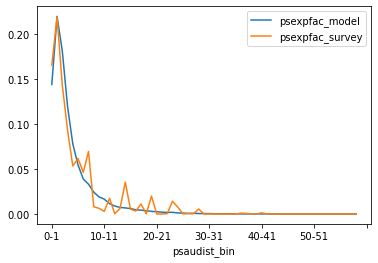

In [25]:
# Create bins
max_bin = 60
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

#### For students in Pierce County

In [26]:
person1 = person[person['CountyName'] == 'Pierce']

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='psaudist_bin'>

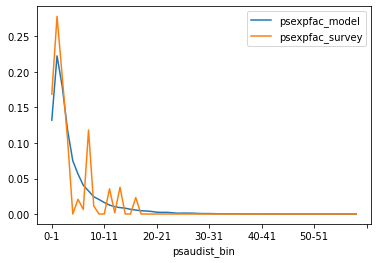

In [27]:
# Create bins
max_bin = 60
person1['psaudist_bin'] = pd.cut(person1['psaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person1[(person1['source'] == 'model') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0)]
df2 = person1[(person1['source'] == 'survey') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

#### For students outside Pierce County

In [28]:
person2 = person[person['CountyName'].isin(['King','Snohomish','Kitsap'])]

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='psaudist_bin'>

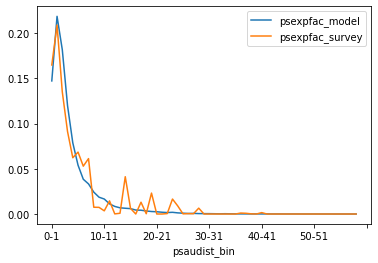

In [29]:
# Create bins
max_bin = 60
person2['psaudist_bin'] = pd.cut(person2['psaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person2[(person2['source'] == 'model') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0)]
df2 = person2[(person2['source'] == 'survey') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

In [30]:
range(0,max_bin,5)

range(0, 60, 5)

<AxesSubplot:xlabel='psaudist_bin'>

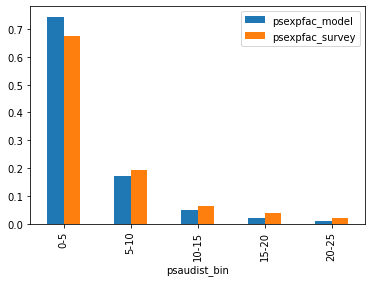

In [31]:
# Create bins
max_bin = 30
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,5)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

#### For students in Pierce County

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='psaudist_bin'>

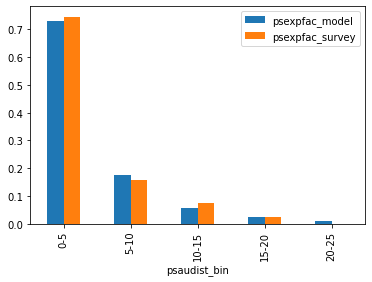

In [32]:
# Create bins
max_bin = 30
person1['psaudist_bin'] = pd.cut(person1['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,5)])
df1 = person1[(person1['source'] == 'model') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0)]
df2 = person1[(person1['source'] == 'survey') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

#### For students outside Pierce County

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='psaudist_bin'>

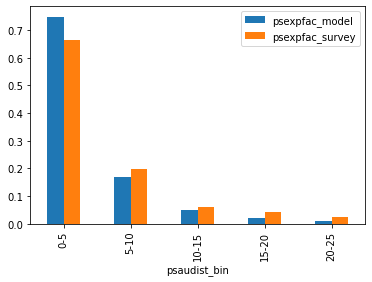

In [33]:
# Create bins
max_bin = 30
person2['psaudist_bin'] = pd.cut(person2['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,5)])
df1 = person2[(person2['source'] == 'model') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0)]
df2 = person2[(person2['source'] == 'survey') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### College Student Usual School Distance

College Students: 160,991


<AxesSubplot:xlabel='psaudist_bin'>

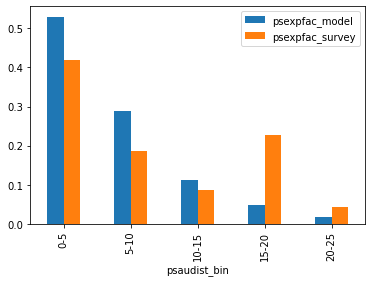

In [34]:
# By studnet type (persontype == 5, 6, 7 )
pd.options.display.float_format = '{:0,.0f}'.format
max_bin = 30
ptype = 5
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('College Students: ' + '{:,}'.format(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')

#### College Students - Pierce County

College Students: 33,551


C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='psaudist_bin'>

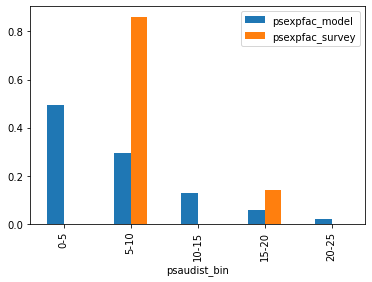

In [35]:
# By studnet type (person1type == 5, 6, 7 )
max_bin = 30
ptype = 5
person1['psaudist_bin'] = pd.cut(person1['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person1[(person1['source'] == 'model') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0) & (person1['pptyp'] == ptype)]
df2 = person1[(person1['source'] == 'survey') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0) & (person1['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('College Students: ' + '{:,}'.format(len(person1[person1['pptyp'] == ptype])))
df.plot(kind='bar')

#### College Students - Other Counties

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


College Students: 127,322


<AxesSubplot:xlabel='psaudist_bin'>

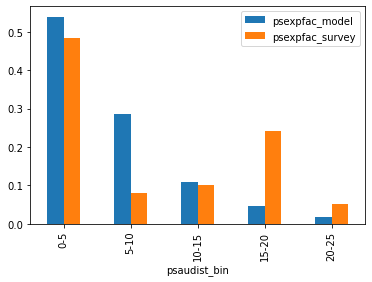

In [36]:
# By studnet type (person2type == 5, 6, 7 )
max_bin = 30
ptype = 5
person2['psaudist_bin'] = pd.cut(person2['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person2[(person2['source'] == 'model') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0) & (person2['pptyp'] == ptype)]
df2 = person2[(person2['source'] == 'survey') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0) & (person2['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('College Students: ' + '{:,}'.format(len(person2[person2['pptyp'] == ptype])))
df.plot(kind='bar')

### High School Student 16+ School Distance

High School Students 16+: 160,857


<AxesSubplot:xlabel='psaudist_bin'>

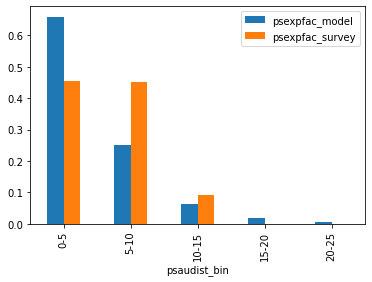

In [37]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 6
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('High School Students 16+: ' + '{:,}'.format(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')

#### High School Student - Pierce County

High School Students 16+: 33,892


C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='psaudist_bin'>

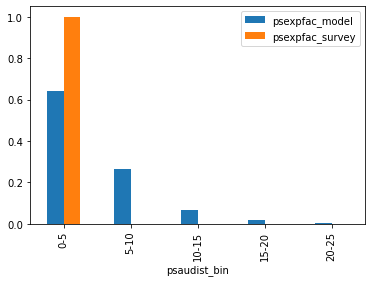

In [38]:
# By studnet type (person1type == 5, 6, 7 )
max_bin = 30
ptype = 6
person1['psaudist_bin'] = pd.cut(person1['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person1[(person1['source'] == 'model') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0) & (person1['pptyp'] == ptype)]
df2 = person1[(person1['source'] == 'survey') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0) & (person1['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('High School Students 16+: ' + '{:,}'.format(len(person1[person1['pptyp'] == ptype])))
df.plot(kind='bar')

#### High School Student - Other Counties

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


High School Students 16+: 126,897


<AxesSubplot:xlabel='psaudist_bin'>

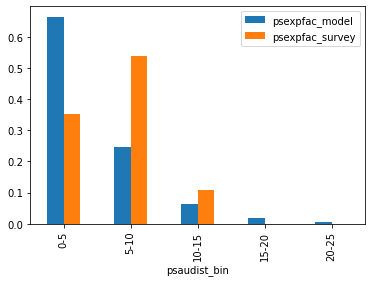

In [39]:
# By studnet type (person2type == 5, 6, 7 )
max_bin = 30
ptype = 6
person2['psaudist_bin'] = pd.cut(person2['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person2[(person2['source'] == 'model') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0) & (person2['pptyp'] == ptype)]
df2 = person2[(person2['source'] == 'survey') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0) & (person2['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('High School Students 16+: ' + '{:,}'.format(len(person2[person2['pptyp'] == ptype])))
df.plot(kind='bar')

### Age 5-15 Student School Distance

Students Age 5-15: 519,956


<AxesSubplot:xlabel='psaudist_bin'>

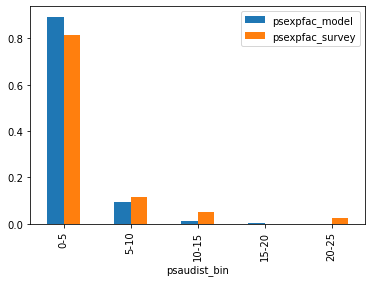

In [40]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 7
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('Students Age 5-15: ' + '{:,}'.format(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')

#### Age 5-15 Student - Pierce County

Students Age 5-15: 111,654


C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='psaudist_bin'>

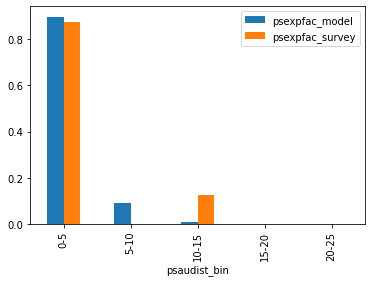

In [41]:
# By studnet type (person1type == 5, 6, 7 )
max_bin = 30
ptype = 7
person1['psaudist_bin'] = pd.cut(person1['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person1[(person1['source'] == 'model') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0) & (person1['pptyp'] == ptype)]
df2 = person1[(person1['source'] == 'survey') & (person1['psaudist'] <= max_bin) & (person1['psaudist'] > 0) & (person1['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('Students Age 5-15: ' + '{:,}'.format(len(person1[person1['pptyp'] == ptype])))
df.plot(kind='bar')

#### Age 5-15 Student - Other Counties

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Students Age 5-15: 389,190


<AxesSubplot:xlabel='psaudist_bin'>

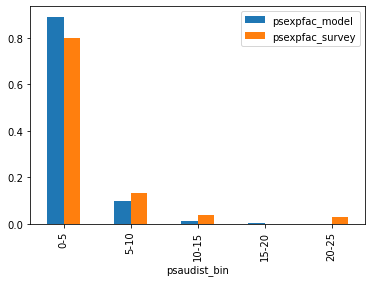

In [42]:
# By studnet type (person2type == 5, 6, 7 )
max_bin = 30
ptype = 7
person2['psaudist_bin'] = pd.cut(person2['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person2[(person2['source'] == 'model') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0) & (person2['pptyp'] == ptype)]
df2 = person2[(person2['source'] == 'survey') & (person2['psaudist'] <= max_bin) & (person2['psaudist'] > 0) & (person2['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('Students Age 5-15: ' + '{:,}'.format(len(person2[person2['pptyp'] == ptype])))
df.plot(kind='bar')